In [18]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import posixpath
import pandas as pd
import wfdb
from scipy.signal import find_peaks,butter, lfilter, freqz
import tqdm

In [ ]:
path_to_csv = 'file_path'
df = pd.read_csv(path_to_csv)
display(df)

In [20]:
csv_path = 'csv\ptbxl_database.csv'
ecg_df = pd.read_csv(csv_path)
display(ecg_df)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [16]:
ecg_df.dtypes

ecg_id                            int64
patient_id                      float64
age                             float64
sex                               int64
height                          float64
weight                          float64
nurse                           float64
site                            float64
device                           object
recording_date                   object
report                           object
scp_codes                        object
heart_axis                       object
infarction_stadium1              object
infarction_stadium2              object
validated_by                    float64
second_opinion                     bool
initial_autogenerated_report       bool
validated_by_human                 bool
baseline_drift                   object
static_noise                     object
burst_noise                      object
electrodes_problems              object
extra_beats                      object
pacemaker                        object


In [6]:
csv_path = 'csv\ptbxl_pl_feature_desc.csv'
pwave_df = pd.read_csv(csv_path)
pwave_df = pwave_df.head(164)
display(pwave_df)
pwave_df.dtypes

,id,unig_feature,12sl_feature,ecgdeli_feature,description,Loinc_concept_ids,unit,comment,consistent_units_unig,consistent_units_12sl
0,P_Amp_X,$ P+_Amp_X if P_Morph_X>0 else P-_Amp_X,P_PeakAmpl_X,PWa_X,P wave amplitude in lead X,"3024893, 3025405, 3026247, 3012776, 3027068, 3...",mV,NaN,0.001,0.001
1,P_DurFull_X,ILM_P_Dur_X,$ P_Dur_X+Pp_Dur_X,PWd_X,Sum of P and P' wave duration in lead X,NaN,ms,NaN,1.000,1.000
2,P_Dur_X,$ P_DurFull_X - P-_Dur_X if P_Morph_X>0 else P...,P_Duration_X,NaN,P wave duration in lead X,"3009784, 3023622, 3019852, 3020390, 3005529, 3...",ms,NaN,1.000,1.000
3,Pp_Amp_X,$ P-_Amp_X if P_Morph_X>0 else P+_Amp_X,PP_PeakAmpl_X,NaN,P' wave amplitude in lead X,"3002979, 3001868, 3000537, 3033317, 3005371, 3...",mV,NaN,0.001,0.001
4,Q_Dur_X,ILM_Q_Dur_X,Q_Duration_X,NaN,Q wave duration in lead X,"3037087,3020600,3009543,3014760,3009132,301612...",ms,NaN,1.000,1.000
...,...,...,...,...,...,...,...,...,...,...
159,PQ_Int_X,NaN,NaN,PQi_X,PQ interval in lead X,NaN,ms,NaN,1.000,1.000
160,QT_IntCorr_X,NaN,NaN,QTci_X,Q-T interval corrected based on Framingham for...,NaN,ms,NaN,1.000,1.000
161,PQ_Int_Global,NaN,NaN,PQi_max,max PQ interval across all leads,NaN,ms,NaN,1.000,1.000
162,HA__Global,NaN,NaN,elHA,"electrical heart axis (1: left axis deviation,...",NaN,integer,NaN,1.000,1.000


id                        object
unig_feature              object
12sl_feature              object
ecgdeli_feature           object
description               object
Loinc_concept_ids         object
unit                      object
comment                   object
consistent_units_unig    float64
consistent_units_12sl    float64
dtype: object

In [14]:
csv_path = 'csv\\twelvesl_features.csv'
twelvesl_df = pd.read_csv(csv_path)
display(twelvesl_df)
display(twelvesl_df.dtypes)

,P_Area_I,P_PeakTime_I,Q_Area_I,Q_PeakTime_I,R_Area_I,R_PeakTime_I,S_Area_I,S_PeakTime_I,QRS_Balance_I,T_Area_I,...,T+_Dur_aVF,T-_Dur_aVF,T+_Amp_aVF,T-_Amp_aVF,T_Morph_aVF,T_DurFull_aVF,P_Dur_Global,P_Found_Global,HR__Global,P_Term_V1
0,0.264,64.0,0.000,0.0,0.737,30.0,0.000,0.0,629.0,0.819,...,208.0,0.0,0.151,0.000,1,208.0,112.0,1,64.0,0.000
1,-0.047,6.0,0.015,8.0,0.794,36.0,1.246,76.0,205.0,2.206,...,0.0,127.0,0.000,-0.078,-1,127.0,66.0,1,75.0,0.000
2,0.000,0.0,0.000,0.0,0.792,38.0,1.389,74.0,141.0,1.155,...,0.0,66.0,0.000,-0.078,-1,66.0,NaN,0,169.0,0.000
3,0.196,74.0,0.000,0.0,0.947,56.0,0.000,0.0,439.0,-0.339,...,0.0,0.0,0.000,0.000,-1,0.0,114.0,1,79.0,0.000
4,0.287,102.0,0.000,0.0,1.021,36.0,0.000,0.0,937.0,0.756,...,104.0,66.0,39.000,-0.034,-2,170.0,136.0,1,92.0,6.612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,0.220,80.0,0.015,10.0,0.961,38.0,0.000,0.0,620.0,0.852,...,208.0,0.0,0.175,0.000,1,208.0,120.0,1,67.0,0.000
21795,0.224,78.0,0.012,6.0,1.022,34.0,0.000,0.0,693.0,0.734,...,167.0,0.0,0.092,0.000,1,167.0,140.0,1,59.0,2.465
21796,0.206,62.0,0.000,0.0,0.789,34.0,0.000,0.0,722.0,0.657,...,182.0,0.0,0.312,0.000,1,182.0,110.0,1,70.0,2.418
21797,0.119,48.0,0.000,0.0,0.961,36.0,0.000,0.0,937.0,1.200,...,180.0,0.0,0.087,0.000,1,180.0,142.0,1,59.0,5.840


P_Area_I          float64
P_PeakTime_I      float64
Q_Area_I          float64
Q_PeakTime_I      float64
R_Area_I          float64
                   ...   
T_DurFull_aVF     float64
P_Dur_Global      float64
P_Found_Global      int64
HR__Global        float64
P_Term_V1         float64
Length: 783, dtype: object


In [15]:
csv_path = 'csv\\ecgdeli_features.csv'
ecgdeli_df = pd.read_csv(csv_path)
display(ecgdeli_df)
display(ecgdeli_df.dtypes)

,ecg_id,PQ_Int_I,PQ_Int_I_iqr,PQ_Int_I_count,PQ_Int_II,PQ_Int_II_iqr,PQ_Int_II_count,PQ_Int_III,PQ_Int_III_iqr,PQ_Int_III_count,...,T_DurFull_aVL_count,T_DurFull_aVR,T_DurFull_aVR_iqr,T_DurFull_aVR_count,T_Dur_Global,T_Dur_Global_iqr,T_Dur_Global_count,HA__Global,HA__Global_iqr,HA__Global_count
0,1,122.0,9.0,11,138.0,6.0,11,204.0,55.0,11,...,11,204.0,72.0,11,316.0,24.0,11,2.0,0.0,1
1,2,146.0,2.0,7,176.0,14.0,7,386.0,30.0,7,...,7,154.0,70.0,7,352.0,123.0,7,4.0,0.0,1
2,3,134.0,6.0,11,136.0,29.0,11,176.0,81.0,11,...,11,208.0,108.0,11,382.0,41.0,11,2.0,0.0,1
3,4,172.0,18.0,13,152.0,28.0,13,172.0,68.0,13,...,13,142.0,8.0,13,256.0,76.0,13,4.0,0.0,1
4,5,138.0,65.0,11,142.0,10.0,11,172.0,32.0,11,...,11,154.0,51.0,11,350.0,102.0,11,4.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21836,174.0,38.0,12,180.0,6.5,12,189.0,14.5,12,...,12,140.0,10.5,12,232.0,91.0,12,2.0,0.0,1
21795,21837,178.0,76.0,10,140.0,20.5,10,203.0,43.5,10,...,10,167.0,80.0,10,363.0,57.5,10,2.0,0.0,1
21796,12722,154.0,18.0,13,150.0,24.0,13,142.0,14.0,13,...,13,148.0,4.0,13,250.0,110.0,13,2.0,0.0,1
21797,14286,10.0,8.0,33,20.0,2.0,33,22.0,6.0,33,...,33,130.0,22.0,33,182.0,14.0,33,5.0,0.0,1


ecg_id                  int64
PQ_Int_I              float64
PQ_Int_I_iqr          float64
PQ_Int_I_count          int64
PQ_Int_II             float64
                       ...   
T_Dur_Global_iqr      float64
T_Dur_Global_count      int64
HA__Global            float64
HA__Global_iqr        float64
HA__Global_count        int64
Length: 532, dtype: object

In [16]:
csv_path = 'csv\\unig_features.csv'
unig_df = pd.read_csv(csv_path)
display(unig_df)
display(unig_df.dtypes)

,ecg_id,P_On_I,P_On_II,P_On_III,P_On_aVR,P_On_aVL,P_On_aVF,P_On_V1,P_On_V2,P_On_V3,...,T-_Dur_aVF,P-_Dur_aVF,P_Amp_aVF,P_Dur_aVF,Pp_Amp_aVF,T_Amp_aVF,Pp_Dur_aVF,Tp_Amp_aVF,T_Dur_aVF,Tp_Dur_aVF
0,13481,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,240.0,...,0.0,0.0,0.107,112.0,0.00,0.122,0.0,0.000,162.0,0.0
1,13522,294.0,294.0,294.0,294.0,294.0,294.0,294.0,294.0,294.0,...,0.0,0.0,0.101,108.0,0.00,0.110,0.0,0.000,134.0,0.0
2,4811,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,284.0,...,0.0,0.0,0.113,122.0,0.00,0.111,0.0,0.000,162.0,0.0
3,8281,268.0,268.0,268.0,268.0,268.0,268.0,268.0,268.0,268.0,...,0.0,0.0,0.066,108.0,0.00,0.181,0.0,0.000,204.0,0.0
4,5746,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0,324.0,...,0.0,0.0,0.115,62.0,0.00,0.231,0.0,0.000,208.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21790,3808,278.0,278.0,278.0,278.0,278.0,278.0,278.0,278.0,NaN,...,0.0,48.0,0.017,22.0,-0.03,0.090,48.0,0.000,184.0,0.0
21791,21336,250.0,250.0,250.0,250.0,250.0,250.0,250.0,250.0,250.0,...,122.0,138.0,-0.013,138.0,0.00,-0.035,0.0,0.017,122.0,100.0
21792,12464,250.0,250.0,250.0,250.0,250.0,250.0,250.0,NaN,250.0,...,0.0,100.0,-0.026,100.0,0.00,0.536,0.0,0.000,214.0,0.0
21793,20363,216.0,216.0,216.0,216.0,216.0,216.0,NaN,216.0,216.0,...,0.0,84.0,-0.014,84.0,0.00,1.083,0.0,0.000,198.0,0.0


ecg_id          int64
P_On_I        float64
P_On_II       float64
P_On_III      float64
P_On_aVR      float64
               ...   
T_Amp_aVF     float64
Pp_Dur_aVF    float64
Tp_Amp_aVF    float64
T_Dur_aVF     float64
Tp_Dur_aVF    float64
Length: 749, dtype: object

In [21]:
dbs = wfdb.get_dbs()
display(dbs)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['ann-pt-summ',
  'Medical Expert Annotations of Unsupported Facts in Doctor-Written and LLM-Generated Patient Summaries'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid u

In [8]:
import os
import requests
from tqdm import tqdm

In [16]:
base_url = "https://physionet.org/files/ptb-xl/1.0.3/records100/00000/"

In [19]:
filenames = [f"{i:05d}_lr.dat" for i in range(1, 101)] + [f"{i:05d}_lr.hea" for i in range(1, 101)]
display(filenames)

['00001_lr.dat',
 '00002_lr.dat',
 '00003_lr.dat',
 '00004_lr.dat',
 '00005_lr.dat',
 '00006_lr.dat',
 '00007_lr.dat',
 '00008_lr.dat',
 '00009_lr.dat',
 '00010_lr.dat',
 '00011_lr.dat',
 '00012_lr.dat',
 '00013_lr.dat',
 '00014_lr.dat',
 '00015_lr.dat',
 '00016_lr.dat',
 '00017_lr.dat',
 '00018_lr.dat',
 '00019_lr.dat',
 '00020_lr.dat',
 '00021_lr.dat',
 '00022_lr.dat',
 '00023_lr.dat',
 '00024_lr.dat',
 '00025_lr.dat',
 '00026_lr.dat',
 '00027_lr.dat',
 '00028_lr.dat',
 '00029_lr.dat',
 '00030_lr.dat',
 '00031_lr.dat',
 '00032_lr.dat',
 '00033_lr.dat',
 '00034_lr.dat',
 '00035_lr.dat',
 '00036_lr.dat',
 '00037_lr.dat',
 '00038_lr.dat',
 '00039_lr.dat',
 '00040_lr.dat',
 '00041_lr.dat',
 '00042_lr.dat',
 '00043_lr.dat',
 '00044_lr.dat',
 '00045_lr.dat',
 '00046_lr.dat',
 '00047_lr.dat',
 '00048_lr.dat',
 '00049_lr.dat',
 '00050_lr.dat',
 '00051_lr.dat',
 '00052_lr.dat',
 '00053_lr.dat',
 '00054_lr.dat',
 '00055_lr.dat',
 '00056_lr.dat',
 '00057_lr.dat',
 '00058_lr.dat',
 '00059_lr.dat

In [9]:
files_to_download = filenames

save_dir = "./ptbxl_specific_chunk/"
os.makedirs(save_dir, exist_ok=True)

for file_name in tqdm(files_to_download):
    file_url = base_url + file_name
    response = requests.get(file_url, stream=True)
    save_path = os.path.join(save_dir, file_name)
    
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

print("Download complete!")

NameError: name 'filenames' is not defined

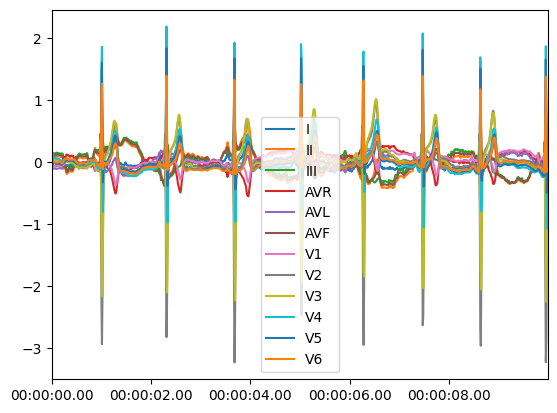

In [29]:
record = wfdb.rdrecord('ptbxl_specific_chunk/00002_lr', sampto=1000)
df = record.to_dataframe()
df.plot();

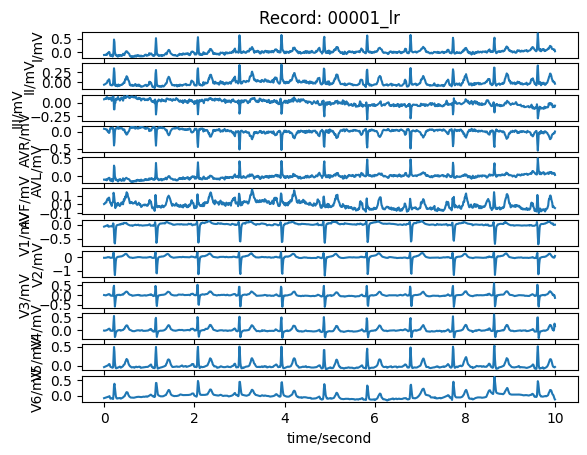

{'record_name': '00001_lr',
 'n_sig': 12,
 'fs': 100,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'p_signal': array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat',
  '00001_lr.dat'],
 'fmt': ['16',
  

In [30]:
record = wfdb.rdrecord('ptbxl_specific_chunk/00001_lr') 
wfdb.plot_wfdb(record=record) 
display(record.__dict__)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import wfdb
from wfdb import processing

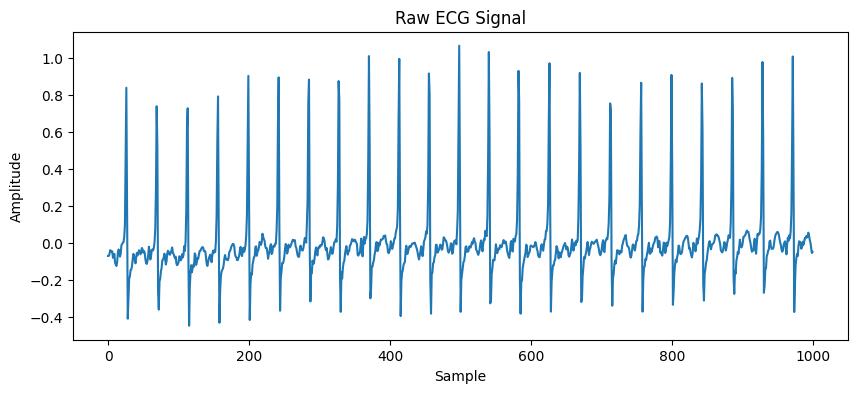

In [15]:
# Load the ECG signal (assuming it's in WFDB format)
record = wfdb.rdrecord('ptbxl_specific_chunk/00020_lr')
signal = record.p_signal[:,0]  # Assuming single-channel ECG

# Plot the raw signal
plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title('Raw ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()




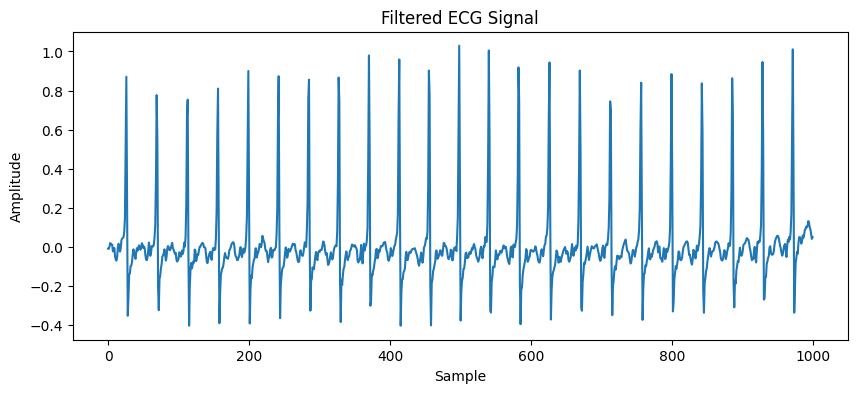

In [16]:
# Bandpass filter the signal to remove noise and baseline wander
def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

fs = record.fs  # Sampling frequency
filtered_signal = bandpass_filter(signal, 0.5, 45.0, fs, order=1)

# Plot the filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal)
plt.title('Filtered ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()



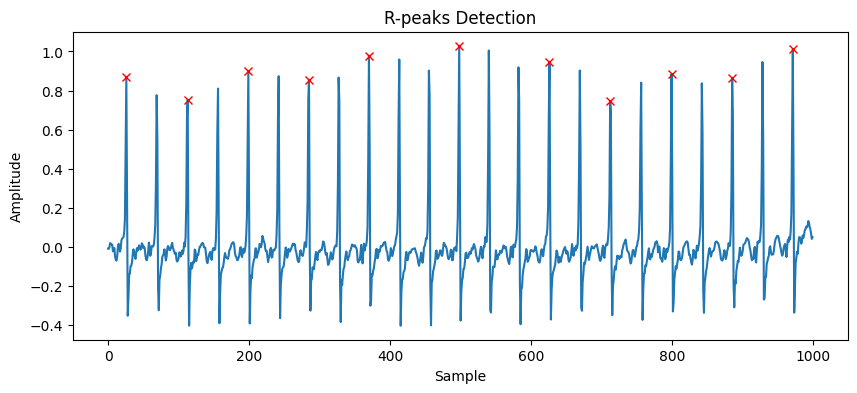

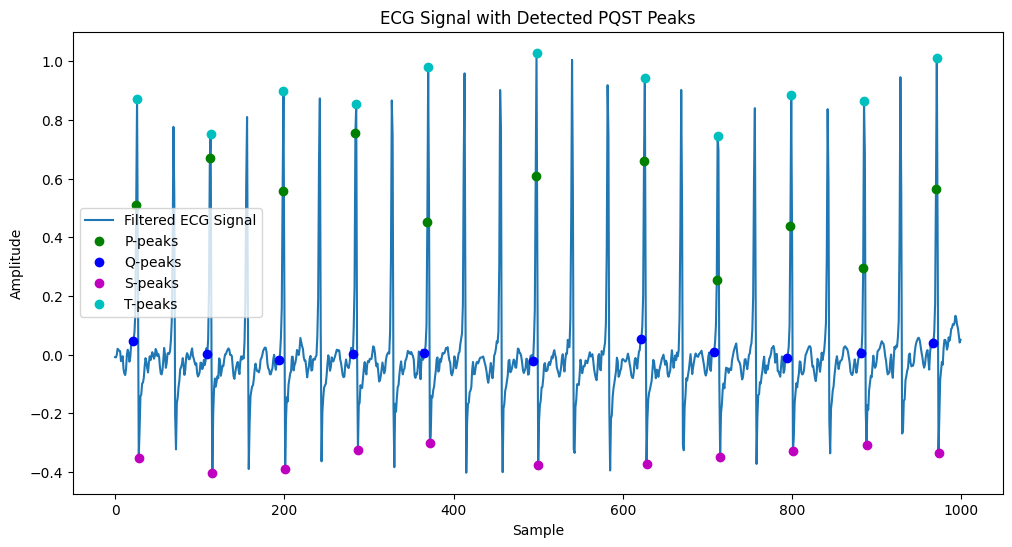

In [17]:
distance = int(0.6 * fs)  
peaks, _ = find_peaks(filtered_signal, distance=distance, height=0.5)

# Plot the signal with R-peaks
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal)
plt.plot(peaks, filtered_signal[peaks], 'rx')  # Mark R-peaks with red 'x'
plt.title('R-peaks Detection')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


def detect_pqrst(signal, r_peaks, fs):
    p_peaks = []
    q_peaks = []
    s_peaks = []
    t_peaks = []

    for r in r_peaks:
        q_window = (max(0, r - int(0.05 * fs)), r)  # 50ms before R
        s_window = (r, min(len(signal), r + int(0.05 * fs)))  # 50ms after R
        p_window = (max(0, r - int(0.2 * fs)), r)  # 200ms before R
        t_window = (r, min(len(signal), r + int(0.4 * fs)))  # 400ms after R

        # Detect Q and S peaks as minimum within their windows
        q_peak = np.argmin(signal[q_window[0]:q_window[1]]) + q_window[0]
        s_peak = np.argmin(signal[s_window[0]:s_window[1]]) + s_window[0]

        # Detect P and T peaks as maximum within their windows
        p_peak = np.argmax(signal[p_window[0]:p_window[1]]) + p_window[0]
        t_peak = np.argmax(signal[t_window[0]:t_window[1]]) + t_window[0]

        q_peaks.append(q_peak)
        s_peaks.append(s_peak)
        p_peaks.append(p_peak)
        t_peaks.append(t_peak)

    return np.array(p_peaks), np.array(q_peaks), np.array(s_peaks), np.array(t_peaks)


p_peaks, q_peaks, s_peaks, t_peaks = detect_pqrst(filtered_signal, peaks, fs)


plt.figure(figsize=(12, 6))
plt.plot(filtered_signal, label='Filtered ECG Signal')
# plt.plot(peaks, filtered_signal[peaks], 'rx', label='R-peaks')
plt.plot(p_peaks, filtered_signal[p_peaks], 'go', label='P-peaks')
plt.plot(q_peaks, filtered_signal[q_peaks], 'bo', label='Q-peaks')
plt.plot(s_peaks, filtered_signal[s_peaks], 'mo', label='S-peaks')
plt.plot(t_peaks, filtered_signal[t_peaks], 'co', label='T-peaks')
plt.legend()
plt.title('ECG Signal with Detected PQST Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

In [10]:
base_url = "https://physionet.org/content/ptb-xl-plus/1.0.1/median_beats/12sl/20000/"

files_to_download = [f"{i:05d}_medians.dat" for i in range(1, 101)] + [f"{i:05d}_medians.hea" for i in range(1, 101)]

save_dir = "./ptbxl_plus_specific_chunk_new/"
os.makedirs(save_dir, exist_ok=True)

# Function to download a file
def download_file(file_url, save_path):
    response = requests.get(file_url, stream=True)
    with open(save_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

# Download the specified files
for filename in tqdm(files_to_download, desc="Downloading files"):
    file_url = base_url + filename
    save_path = os.path.join(save_dir, filename)
    download_file(file_url, save_path)

print("Download complete!")


Download complete!


In [83]:
import neurokit2 as nk

In [87]:
# Retrieve ECG data from data folder
ecg_signal = nk.data(dataset="ecg_1000hz")
# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=1000)

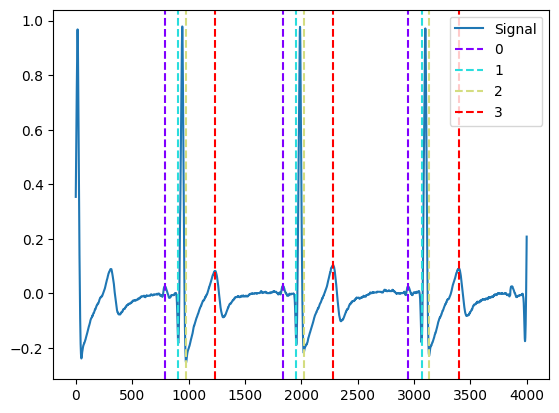

In [105]:
_, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak")

plot = nk.events_plot([waves_peak['ECG_P_Peaks'][:3], 
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3],
                       waves_peak['ECG_T_Peaks'][:3]], ecg_signal[:4000])




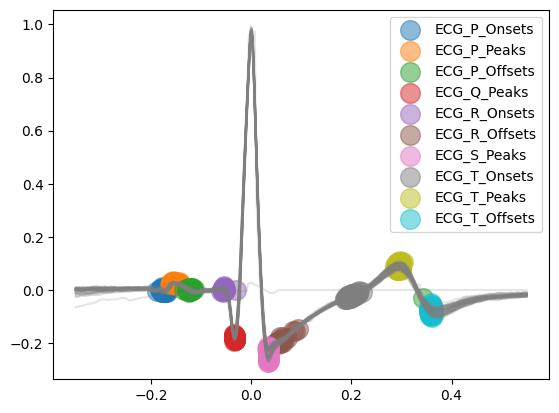

In [94]:
# Delineate the ECG signal
signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, 
                                         rpeaks, 
                                         sampling_rate=1000, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='all')

In [107]:
folder_path = 'ptbxl_specific_chunk'

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith('.hea'):
        base_filename = os.path.splitext(filename)[0]
        record = wfdb.rdrecord(os.path.join(folder_path, base_filename))
        df = pd.DataFrame(record.p_signal, columns=[f'signal_{i}' for i in range(record.p_signal.shape[1])])
        df['record'] = base_filename
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

display(combined_df)


,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,signal_10,signal_11,record
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079,00001_lr
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074,00001_lr
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069,00001_lr
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064,00001_lr
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058,00001_lr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.155,0.134,-0.021,-0.144,0.088,0.056,-0.051,0.237,0.220,0.282,0.324,0.279,00100_lr
99996,0.220,0.177,-0.043,-0.198,0.131,0.067,-0.076,0.256,0.266,0.334,0.375,0.324,00100_lr
99997,0.274,0.232,-0.042,-0.253,0.158,0.095,-0.085,0.268,0.311,0.391,0.435,0.381,00100_lr
99998,0.314,0.283,-0.031,-0.298,0.172,0.126,-0.096,0.277,0.342,0.428,0.477,0.423,00100_lr


In [110]:
import sweetviz as sv
report = sv.analyze([combined_df, 'record'])

                                             |                                             | [  0%]   00:00 ->…

In [111]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


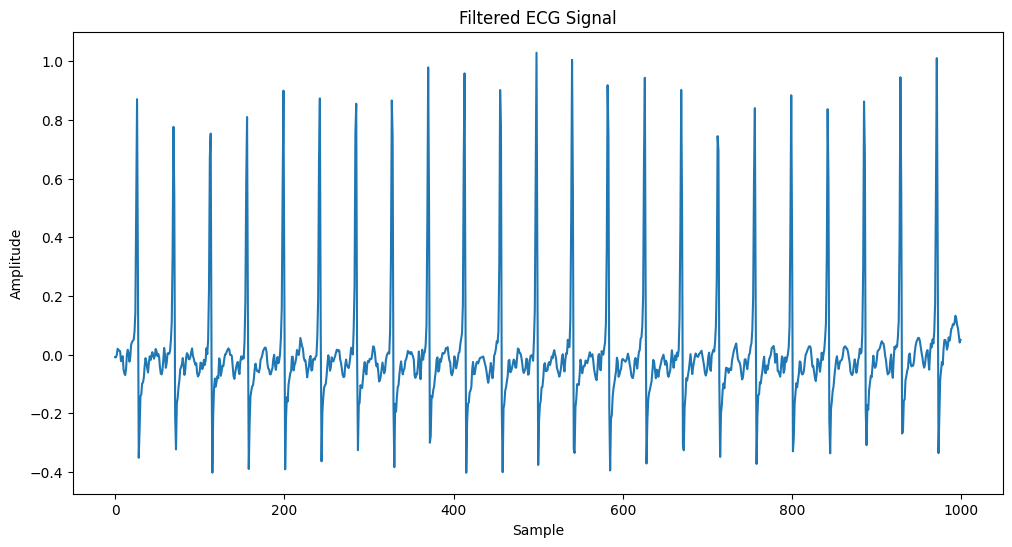

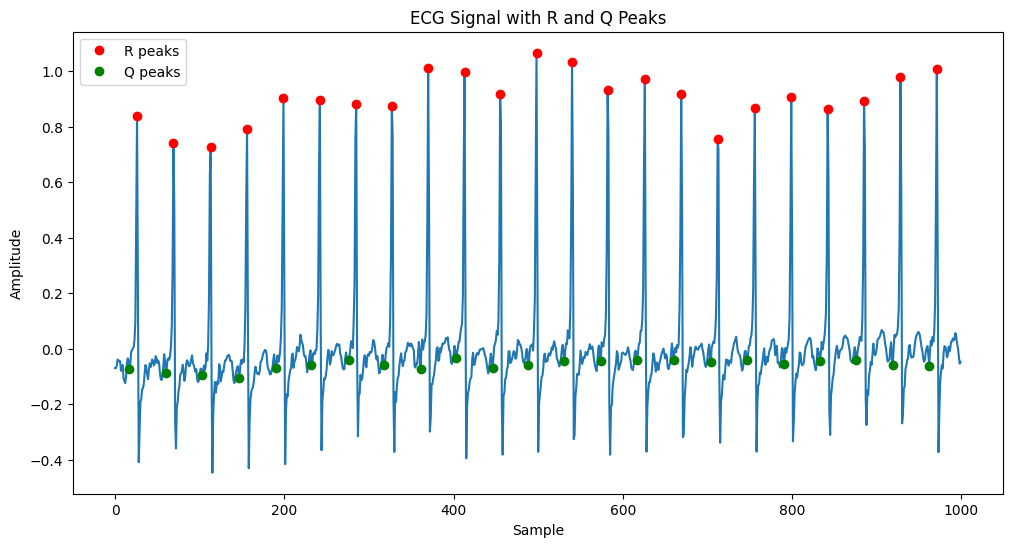

In [62]:
record = wfdb.rdrecord('ptbxl_specific_chunk/00020_lr')
signal = record.p_signal[:,0] 

def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

fs = record.fs  
filtered_signal = bandpass_filter(signal, 0.5, 45.0, fs, order=1)

# filtered signal
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal)
plt.title('Filtered ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()


r_peaks, _ = find_peaks(signal, distance=0.2*record.fs, prominence=0.5)  # Adjust parameters as needed

# Q peaks
q_peaks = []
for r_peak in r_peaks:
    window_start = max(0, r_peak - int(0.1*record.fs))
    window = signal[window_start:r_peak]
    q_peak = window_start + np.argmin(window)
    q_peaks.append(q_peak)

# Signal with identified R and Q peaks
plt.figure(figsize=(12, 6))
plt.plot(signal)
plt.plot(r_peaks, signal[r_peaks], 'ro', label='R peaks')
plt.plot(q_peaks, signal[q_peaks], 'go', label='Q peaks')
plt.title('ECG Signal with R and Q Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()